# Beta bias (?) sim

In [170]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr
%matplotlib inline

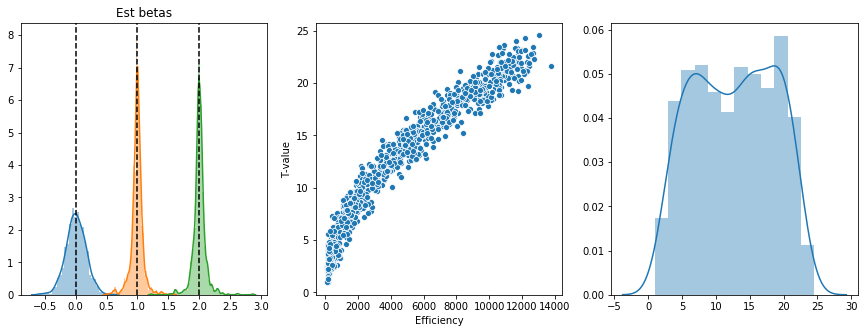

In [171]:
beta = np.array([0, 1, 2])
iters = 1000
N = 1000
K = beta.size - 1
con = np.array([0, -1, 1])

est_beta = np.zeros((iters, beta.size))
eff = np.zeros(iters)
var_cbeta = np.zeros(iters)
tval = np.zeros(iters)
for i in range(iters):
    var = np.random.uniform(0.5, 5)
    X = np.c_[np.ones(N), np.random.normal(0, var, size=(N, K))]
    y = X @ beta + np.random.normal(0, 5, N)
    XtXi = np.linalg.inv(X.T @ X)
    eff[i] = 1 / (con @ XtXi @ con.T)
    est_beta[i, :] = XtXi @ X.T @ y
    noise = np.sum((y - X @ est_beta[i, :]) ** 2) / (N - beta.size)
    var_cbeta[i] = np.sqrt(noise * (1 / eff[i]))
    tval[i] = (con @ est_beta[i, :]) / var_cbeta[i]
    
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
for i in range(beta.size):
    sns.distplot(est_beta[:, i], ax=axes[0])
    axes[0].axvline(beta[i], ls='--', c='k')
    axes[0].set_title("Est betas")
    
sns.scatterplot(eff, tval, ax=axes[1])
axes[1].set_xlabel("Efficiency")
axes[1].set_ylabel("T-value")

sns.distplot(tval, ax=axes[2])

In [164]:
## let's make it more realistic

In [174]:
import numpy as np

def double_gamma(x, lag=6, a2=12, b1=0.9, b2=0.9, c=0.35):
    a1 = lag
    d1 = a1 * b1
    d2 = a2 * b2
    return np.array([(t/(d1))**a1 * np.exp(-(t-d1)/b1) - c*(t/(d2))**a2 * np.exp(-(t-d2)/b2) for t in x])

def single_gamma(x, lag=6, b=0.9):
    a = lag
    d = a * b
    return (x/d)**a * np.exp(-(x-d)/b)

time_points = np.arange(25)  
dg_hrf = double_gamma(time_points, lag=6)

In [190]:
# constrain trial design; let each trial take 3 "TRs" (time points, rows of the design matrix).  TR1=cue, TR2=stim, TR3=baseline
# 50% trial type 1, 50% trial type 2.
K = 3
n_row_per_cue = 500
X_ = np.vstack((np.tile([1, 0, 0], n_row_per_cue).reshape(n_row_per_cue, K),
                np.tile([0, 1, 0], n_row_per_cue).reshape(n_row_per_cue, K)))

# permute cue order
perm = np.arange(X_.shape[0])
np.random.shuffle(perm)
X_ = X_[perm]

# add stimulus, baseline
X_[1::3] = np.tile([0,0,1], X_[1::3].shape[0]).reshape((X_[1::3].shape[0], K))   # stimulus always after cue
X_[2::3] = np.zeros(X_[2::3].shape)

# convolve
# for col in range(1, X_.shape[1]):
#     X_[:,col] = np.convolve(X_[:,col], dg_hrf)[:X_.shape[0]]

In [191]:
X_[:10]

array([[1, 0, 0],
       [0, 0, 1],
       [0, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 0],
       [0, 1, 0]])

code shamelessly stolen from lukas

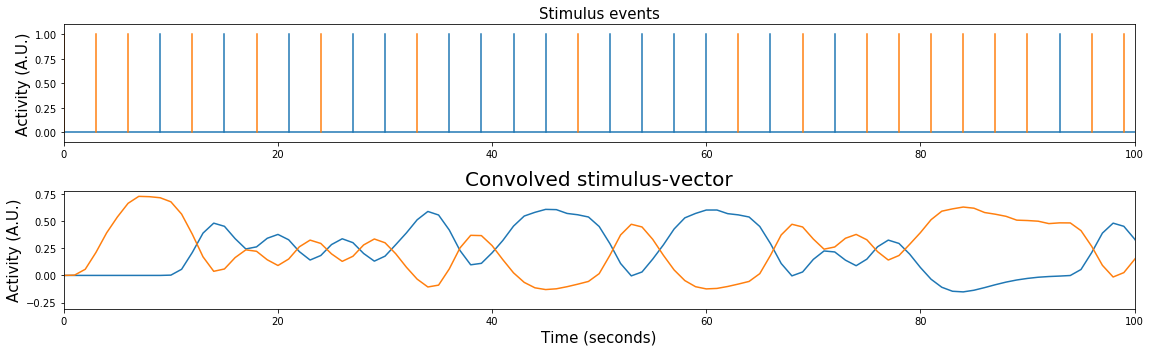

In [194]:
random_stim_vector2 = X_[:,0]
random_stim_vector3 = X_[:,1]

plt.figure(figsize=(16, 5))
plt.subplot(2, 1, 1)

plt.axhline(0)
for i, event in enumerate(random_stim_vector3):
    if event != 0.0:
        plt.plot((i, i), (0, 1), 'k-', c='tab:blue')
for i, event in enumerate(random_stim_vector2):
    if event != 0.0:
        plt.plot((i, i), (0, 1), 'k-', c='tab:orange')

plt.xlim((0, 100))
plt.ylim((-0.1, 1.1))
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.title('Stimulus events', fontsize=15)

convolved_stim_vector2 = np.convolve(random_stim_vector2 * .5, dg_hrf, 'full')[:random_stim_vector2.size]
convolved_stim_vector3 = np.convolve(random_stim_vector3 * .5, dg_hrf, 'full')[:random_stim_vector3.size]
plt.subplot(2, 1, 2)
plt.plot(convolved_stim_vector3)
plt.plot(convolved_stim_vector2, c='tab:orange')
plt.xlim(0, 100)
plt.title('Convolved stimulus-vector', fontsize=20)
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.xlabel('Time (seconds)', fontsize=15)

plt.tight_layout()
plt.show()

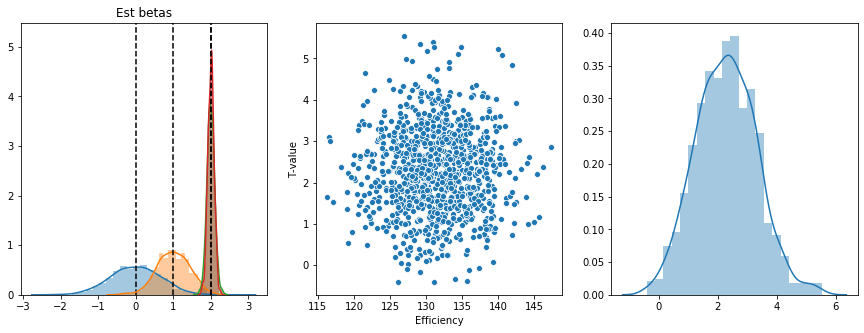

In [386]:
beta = np.array([0, 1, 2, 2])
iters = 1000
N = 1000
n_row_per_cue = int(N/2)
K = beta.size - 1
con = np.array([0, -1, 1, 0])


est_beta = np.zeros((iters, beta.size))
eff = np.zeros(iters)
var_cbeta = np.zeros(iters)
tval = np.zeros(iters)
for i in range(iters):
    var = np.random.uniform(0.5, 5)
    X_ = np.vstack((np.tile([1, 0, 0], n_row_per_cue).reshape(n_row_per_cue, K),
                    np.tile([0, 1, 0], n_row_per_cue).reshape(n_row_per_cue, K)))

    # permute cue order
    perm = np.arange(X_.shape[0])
    np.random.shuffle(perm)
    X_ = X_[perm]

    # add stimulus, baseline
    X_[1::3] = np.tile([0,0,1], X_[1::3].shape[0]).reshape((X_[1::3].shape[0], K))   # stimulus always after cue
    X_[2::3] = np.zeros(X_[2::3].shape)

    # convolve
    for col in range(1, X_.shape[1]):
        X_[:,col] = np.convolve(X_[:,col], dg_hrf, 'full')[:X_.shape[0]]
    X = np.c_[np.ones(N), X_]

    y = X @ beta + np.random.normal(0, 5, N)
    XtXi = np.linalg.inv(X.T @ X)
    eff[i] = 1 / (con @ XtXi @ con.T)
    est_beta[i, :] = XtXi @ X.T @ y
    noise = np.sum((y - X @ est_beta[i, :]) ** 2) / (N - beta.size)
    var_cbeta[i] = np.sqrt(noise * (1 / eff[i]))
    tval[i] = (con @ est_beta[i, :]) / var_cbeta[i]
    
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
for i in range(beta.size):
    sns.distplot(est_beta[:, i], ax=axes[0])
    axes[0].axvline(beta[i], ls='--', c='k')
    axes[0].set_title("Est betas")
    
sns.scatterplot(eff, tval, ax=axes[1])
axes[1].set_xlabel("Efficiency")
axes[1].set_ylabel("T-value")

sns.distplot(tval, ax=axes[2])

## even more realistic, simulate trial timing, add jitters

In [387]:
def make_design_matrix(tr):
    jitter_durations = np.array([1,2,4,8]) * 2/3
    probs = np.array([8, 4, 2, 1])
    probs = probs/probs.sum()

    run_duration = 9000  # seconds, too long for realistic purposes but for illustration/simulation
    cue1_onsets = []
    cue2_onsets = []
    stim_onsets = []

    t = 0
    while t < run_duration:
        is_cue_1 = np.random.sample(1) < .5
        if is_cue_1:
            cue1_onsets.append(t)
        else:
            cue2_onsets.append(t)

        cue_duration = np.random.choice(jitter_durations, p=probs)
        t += cue_duration
        if t > run_duration:
            break

        stim_onsets.append(t)
        stim_duration = np.random.choice(jitter_durations, p=probs)

        t += stim_duration
        if t > run_duration:
            break

        # iti
        t += np.random.choice(jitter_durations, p=probs)

    # make oversampled design matrix, 0.1 second resolution
    X_ = np.zeros((run_duration*10, 3))

    cue1_onsets = (np.array(cue1_onsets)*10).astype(int)
    cue2_onsets = (np.array(cue2_onsets)*10).astype(int)
    stim_onsets = (np.array(stim_onsets)*10).astype(int)

    X_[cue1_onsets, 0] = 1
    X_[cue2_onsets, 1] = 1
    X_[stim_onsets, 2] = 1
    
    # sample double gamma in 0.1-seconds resolution before convolution
    time_points = np.arange(0, 25, .1)
    dg_hrf = double_gamma(time_points, lag=6)
    
    # convolve
    for col in range(0, X_.shape[1]):
        X_[:,col] = np.convolve(X_[:,col], dg_hrf, 'full')[:X_.shape[0]]
    
    # append intercept
    X_ = np.c_[np.ones(X_.shape[0]), X_]

    # downsample to TR
    sample_rows = tr*10
    return X_[::sample_rows,:]

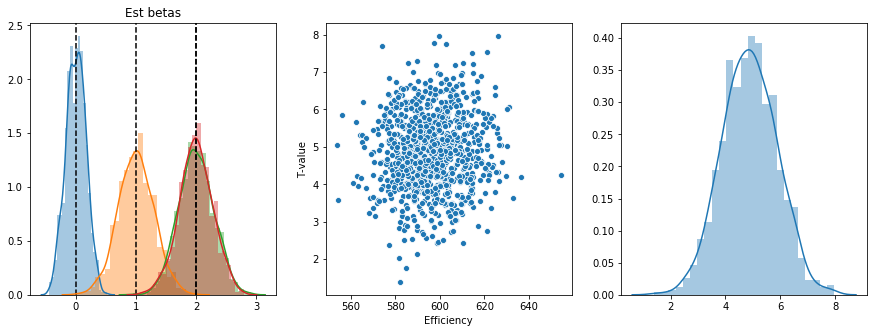

In [388]:
beta = np.array([0, 1, 2, 2])
iters = 1000
N = 1000
n_row_per_cue = int(N/2)
K = beta.size - 1
con = np.array([0, -1, 1, 0])


est_beta = np.zeros((iters, beta.size))
eff = np.zeros(iters)
var_cbeta = np.zeros(iters)
tval = np.zeros(iters)
for i in range(iters):
    X = make_design_matrix(3)
    
    y = X @ beta + np.random.normal(0, 5, X.shape[0])
    XtXi = np.linalg.inv(X.T @ X)
    eff[i] = 1 / (con @ XtXi @ con.T)
    est_beta[i, :] = XtXi @ X.T @ y
    noise = np.sum((y - X @ est_beta[i, :]) ** 2) / (X.shape[0] - beta.size)
    var_cbeta[i] = np.sqrt(noise * (1 / eff[i]))
    tval[i] = (con @ est_beta[i, :]) / var_cbeta[i]
    
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
for i in range(beta.size):
    sns.distplot(est_beta[:, i], ax=axes[0])
    axes[0].axvline(beta[i], ls='--', c='k')
    axes[0].set_title("Est betas")
    
sns.scatterplot(eff, tval, ax=axes[1])
axes[1].set_xlabel("Efficiency")
axes[1].set_ylabel("T-value")

sns.distplot(tval, ax=axes[2])

In [262]:
## Final step; simulate full design
def simulate_RL(n_trials, alpha=0.1, beta=2):
    v0 = np.array([0.5, 0.5])
    QQ = np.zeros((n_trials, 2))
    QQ[0,:] = [0.5, 0.5]
    PP = np.zeros((n_trials, 2))
    PEs = np.zeros((n_trials, 1))
    ps = [0.7, 0.3]
    choices = []
    
    for t in range(0, n_trials):
        ###### Simulate choice
        thisQQ = QQ[t,:].copy()

        # softmax
        p_a = np.exp(beta*thisQQ)
        p_a = p_a/np.sum(p_a)
        PP[t,:] = p_a
        choice = 0 if np.random.sample(size=1) < p_a[0] else 1
        choices.append(choice)

        #sample reward, update
        reward = 1 if np.random.sample(size=1) < ps[choice] else 0
        pe = reward - thisQQ[choice]
        PEs[t] = pe
        thisQQ[choice] = thisQQ[choice] + alpha*pe
        
        if t < (n_trials-1):
            QQ[t+1,:] = thisQQ
    
    return QQ, PEs, PP


In [391]:
def make_design_matrix_full(TR=3, run_duration_target=900, verbose=True):
    ###
    cue1_onsets = []
    cue2_onsets = []
    stim_onsets = []
    highlight_onsets = []
    feedback_onsets = []
    iti_onsets = []

    if TR == 2:
        base_jit = 1/3        # .25, .5, 1, 2 seconds
    elif TR == 3:
        base_jit = 2/3        # .67, 1.33, 2.67, 5.33 seconds

    jitter_times = np.array([1,2,4,8])*base_jit
    probs = np.array([8, 4, 2, 1])
    probs = probs/probs.sum()

    n_trials = 0
    this_cue = 1
    this_cue_trials_left = 0
    t = 0
    while t < run_duration_target:
        if this_cue_trials_left == 0:
            # switch to other cue
            if this_cue == 0:
                this_cue = 1
            else:
                this_cue = 0
            # how many trials with this cue will be shown?
            this_cue_trials_left = np.clip(np.random.exponential(scale=3, size=1).round(), 1, 6)[0]

        this_cue_trials_left -= 1

        if this_cue == 0:
            cue1_onsets.append(t)
        else:
            cue2_onsets.append(t)
        # never draw the 5.33 seconds delay for a cue - I'm afraid that'll influence behavior
        cue_duration = np.random.choice(jitter_times[:-1], p=probs[:-1]/probs[:-1].sum())
        t += cue_duration
        
        # prevent any events from occuring after run_target_duration - this is ugly I know
        if t > run_duration_target:
            break
    
        stim_onsets.append(t)
        stimulus_duration = 1.5
        t += stimulus_duration
        if t > run_duration_target:
            break

        # jitter to decorrelate stimulus & highlight - a bit unfortunate but probably necessary
        t += np.random.choice(jitter_times, p=probs)
        if t > run_duration_target:
            break

        highlight_onsets.append(t)
        highlight_duration = np.random.choice(jitter_times, p=probs)
        t += highlight_duration
        if t > run_duration_target:
            break

        feedback_onsets.append(t)
        feedback_duration = .75 #np.random.choice(jitter_long, p=probs)

        if t > run_duration_target:
            break

        iti_onsets.append(t)
        iti_duration = np.random.choice(jitter_times, p=probs)

        # sample from baseline every roughly 10th trial
        if n_trials % 10 == 0:
            iti_duration += 5
        t += iti_duration
        if t > run_duration_target:
            break

        n_trials += 1
    
    # make oversampled design matrix, 0.1 second resolution
    X_ = np.zeros((run_duration_target*10, 5))

    cue1_onsets = (np.array(cue1_onsets)*10).astype(int)
    cue2_onsets = (np.array(cue2_onsets)*10).astype(int)
    stim_onsets = (np.array(stim_onsets)*10).astype(int)
    highlight_onsets = (np.array(highlight_onsets)*10).astype(int)
    feedback_onsets = (np.array(feedback_onsets)*10).astype(int)

    X_[cue1_onsets, 0] = 1
    X_[cue2_onsets, 1] = 1
    X_[stim_onsets, 2] = 1
    
    # parametric modulation of highlight & feedback
    QQ, PE, PP = simulate_RL(n_trials+1, alpha=.1, beta=2)  # simulate 1 trial extra
    QQ_covariate = QQ[:,0] - QQ[:,1]
    pe_covariate = PE[:,0]
    X_[highlight_onsets, 3] = QQ_covariate[:highlight_onsets.shape[0]]  #.. but clip off any additional trial
    X_[feedback_onsets, 4] = pe_covariate[:feedback_onsets.shape[0]] #
    
    # sample double gamma in 0.1-seconds resolution before convolution
    time_points = np.arange(0, 25, .1)
    dg_hrf = double_gamma(time_points, lag=6)
    
    # convolve
    for col in range(0, X_.shape[1]):
        X_[:,col] = np.convolve(X_[:,col], dg_hrf, 'full')[:X_.shape[0]]
    
    # append intercept
    X_ = np.c_[np.ones(X_.shape[0]), X_]

    # downsample to TR
    sample_rows = TR*10
    return X_[::sample_rows,:]

X = make_design_matrix_full(TR=3, run_duration_target=900)

In [392]:
beta = np.array([0, 1, 2, .5, 2, 1])
iters = 1000
K = beta.size - 1
con = np.array([0, -1, 1, 0, 0, 0])

est_beta = np.zeros((iters, beta.size))
eff = np.zeros(iters)
var_cbeta = np.zeros(iters)
tval = np.zeros(iters)
for i in range(iters):
    if i%100 == 0:
        print('.', end='')
    X = make_design_matrix_full(3, run_duration_target=900*3)
    
    y = X @ beta + np.random.normal(0, .1, X.shape[0])
    XtXi = np.linalg.inv(X.T @ X)
    eff[i] = 1 / (con @ XtXi @ con.T)
    est_beta[i, :] = XtXi @ X.T @ y
    noise = np.sum((y - X @ est_beta[i, :]) ** 2) / (X.shape[0] - beta.size)
    var_cbeta[i] = np.sqrt(noise * (1 / eff[i]))
    tval[i] = (con @ est_beta[i, :]) / var_cbeta[i]
    
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
for i in range(beta.size):
    sns.distplot(est_beta[:, i], ax=axes[0])
    axes[0].axvline(beta[i], ls='--', c='k')
    axes[0].set_title("Est betas")
    
sns.scatterplot(eff, tval, ax=axes[1])
axes[1].set_xlabel("Efficiency")
axes[1].set_ylabel("T-value")

sns.distplot(tval, ax=axes[2])

........

IndexError: index 27000 is out of bounds for axis 0 with size 27000

In [ ]:
pearsonr(eff, tval)

## Add time derivatives to design matrix

In [ ]:
def make_design_matrix_full(TR=3, run_duration_target=900, verbose=True):
    ###
    cue1_onsets = []
    cue2_onsets = []
    stim_onsets = []
    highlight_onsets = []
    feedback_onsets = []
    iti_onsets = []

    if TR == 2:
        base_jit = 1/3        # .25, .5, 1, 2 seconds
    elif TR == 3:
        base_jit = 2/3        # .67, 1.33, 2.67, 5.33 seconds

    jitter_times = np.array([1,2,4,8])*base_jit
    probs = np.array([8, 4, 2, 1])
    probs = probs/probs.sum()

    n_trials = 0
    this_cue = 1
    this_cue_trials_left = 0
    t = 0
    while t < run_duration_target:
        if this_cue_trials_left == 0:
            # switch to other cue
            if this_cue == 0:
                this_cue = 1
            else:
                this_cue = 0
            # how many trials with this cue will be shown?
            this_cue_trials_left = np.clip(np.random.exponential(scale=3, size=1).round(), 1, 6)[0]

        this_cue_trials_left -= 1

        if this_cue == 0:
            cue1_onsets.append(t)
        else:
            cue2_onsets.append(t)
        # never draw the 5.33 seconds delay for a cue - I'm afraid that'll influence behavior
        cue_duration = np.random.choice(jitter_times[:-1], p=probs[:-1]/probs[:-1].sum())
        t += cue_duration
        
        # prevent any events from occuring after run_target_duration - this is ugly I know
        if t > run_duration_target:
            break
    
        stim_onsets.append(t)
        stimulus_duration = 1.5
        t += stimulus_duration
        if t > run_duration_target:
            break

        # jitter to decorrelate stimulus & highlight - a bit unfortunate but probably necessary
        t += np.random.choice(jitter_times, p=probs)
        if t > run_duration_target:
            break

        highlight_onsets.append(t)
        highlight_duration = np.random.choice(jitter_times, p=probs)
        t += highlight_duration
        if t > run_duration_target:
            break

        feedback_onsets.append(t)
        feedback_duration = .75 #np.random.choice(jitter_long, p=probs)

        if t > run_duration_target:
            break

        iti_onsets.append(t)
        iti_duration = np.random.choice(jitter_times, p=probs)

        # sample from baseline every roughly 10th trial
        if n_trials % 10 == 0:
            iti_duration += 5
        t += iti_duration
        if t > run_duration_target:
            break

        n_trials += 1
    
    # make oversampled design matrix, 0.1 second resolution
    X_ = np.zeros((run_duration_target*10, 10))

    cue1_onsets = (np.array(cue1_onsets)*10).astype(int)
    cue2_onsets = (np.array(cue2_onsets)*10).astype(int)
    stim_onsets = (np.array(stim_onsets)*10).astype(int)
    highlight_onsets = (np.array(highlight_onsets)*10).astype(int)
    feedback_onsets = (np.array(feedback_onsets)*10).astype(int)

    X_[cue1_onsets, 0] = 1
    X_[cue1_onsets, 1] = 1 # derivative
    X_[cue2_onsets, 2] = 1
    X_[cue2_onsets, 3] = 1 # derivative
    X_[stim_onsets, 4] = 1
    X_[stim_onsets, 5] = 1 # derivative
    
    # parametric modulation of highlight & feedback
    QQ, PE, PP = simulate_RL(n_trials+1, alpha=.1, beta=2)  # simulate 1 trial extra
    QQ_covariate = QQ[:,0] - QQ[:,1]
    pe_covariate = PE[:,0]
    X_[highlight_onsets, 6] = QQ_covariate[:highlight_onsets.shape[0]]  #.. but clip off any additional trial
    X_[highlight_onsets, 7] = 1  # derivative
    X_[feedback_onsets, 8] = pe_covariate[:feedback_onsets.shape[0]] #
    X_[feedback_onsets, 9] = 1  # derivative
    
    # sample double gamma in 0.1-seconds resolution before convolution
    time_points = np.arange(0, 25, .1)
    dg_hrf = double_gamma(time_points, lag=6)
    
    # convolve
    for col in range(0, X_.shape[1]):
        if col in [0,2,4,6,8]:
            X_[:,col] = np.convolve(X_[:,col], dg_hrf)[:X_.shape[0]]
        else:
            X_[:,col] = np.convolve(X_[:,col], np.diff(dg_hrf))[:X_.shape[0]]  # convolve with derivative
    
    # append intercept
    X_ = np.c_[np.ones(X_.shape[0]), X_]

    # downsample to TR
    sample_rows = TR*10
    return X_[::sample_rows,:]

X = make_design_matrix_full(TR=3, run_duration_target=900)

In [ ]:
beta = np.array([0, .2, 0, .5, 0, -.7, 0, 1, 0, .5, 0])
iters = 1000
K = beta.size - 1
con = np.array([0, -1, 0, 1, 0, 0, 0, 0, 0, 0, 0])

est_beta = np.zeros((iters, beta.size))
copes = np.zeros(iters)
eff = np.zeros(iters)
var_cbeta = np.zeros(iters)
tval = np.zeros(iters)
for i in range(iters):
    if i%100 == 0:
        print('.', end='')
    X = make_design_matrix_full(3, run_duration_target=900*3)
    
    y = X @ beta + np.random.normal(0, .8, X.shape[0])
    XtXi = np.linalg.inv(X.T @ X)
    eff[i] = 1 / (con @ XtXi @ con.T)
    est_beta[i, :] = XtXi @ X.T @ y
    noise = np.sum((y - X @ est_beta[i, :]) ** 2) / (X.shape[0] - beta.size)
    var_cbeta[i] = np.sqrt(noise * (1 / eff[i]))
    copes[i] = con @ est_beta[i, :]
    tval[i] = copes[i] / var_cbeta[i]
    
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
for i in range(beta.size):
    sns.distplot(est_beta[:, i], ax=axes[0])
    axes[0].axvline(beta[i], ls='--', c='k')
    axes[0].set_title("Est betas")
    
sns.scatterplot(eff, tval, ax=axes[1])
axes[1].set_xlabel("Efficiency")
axes[1].set_ylabel("T-value")

sns.distplot(tval, ax=axes[2])

In [ ]:
sns.scatterplot(eff, copes)

Still no negative effect. What happens when we use an AR(1)-model? Despite the data not being generated by an AR(1) model

In [ ]:
from scipy.linalg import toeplitz

In [ ]:
beta = np.array([0, .2, 0, .5, 0, .5, 0, 2, 0, 1, 0])
iters = 1000
K = beta.size - 1
con = np.array([0, -1, 0, 1, 0, 0, 0, 0, 0, 0, 0])

eff = np.zeros(iters)
est_beta = np.zeros((iters, beta.size))
est_beta_AR1 = np.zeros((iters, beta.size))
copes = np.zeros(iters)
copes_AR1 = np.zeros(iters)
var_cbeta = np.zeros(iters)
var_cbeta_AR1 = np.zeros(iters)
tval = np.zeros(iters)
tval_AR1 = np.zeros(iters)

for i in range(iters):
    if i%100 == 0:
        print('.', end='')
        
    # Simulate
    X = make_design_matrix_full(3, run_duration_target=900*3)
    y = X @ beta + np.random.normal(0, .01, X.shape[0])
    
    # OLS
    XtXi = np.linalg.inv(X.T @ X)
    eff[i] = 1 / (con @ XtXi @ con.T)
    est_beta[i, :] = XtXi @ X.T @ y
    resid = y-(X @ est_beta[i,:])
    noise = np.sum((y - X @ est_beta[i, :]) ** 2) / (X.shape[0] - beta.size)
    var_cbeta[i] = np.sqrt(noise * (1 / eff[i]))
    copes[i] = con @ est_beta[i, :]
    tval[i] = copes[i] / var_cbeta[i]

    # get AR(1) correlation
    ols_ar1_resid = np.linalg.lstsq(np.vstack([np.ones(resid[:-1].shape), resid[:-1]]).T, resid[1:,np.newaxis])
    rho = ols_ar1_resid[0][1]  # lag1 correlation

    # make whitening matrix W using cholesky decomposition
    order = toeplitz(np.arange(len(y)))
    V = rho ** order
    W = np.linalg.cholesky(np.linalg.pinv(V))

    # ok, now prewhiten
    y_w = W @ y
    X_w = W @ X
    
    # same OLS but with prewhitened DM and y
    XtXi_w = np.linalg.inv(X_w.T @ X_w)
    est_beta_AR1[i,:] = XtXi_w @ X_w.T @ y_w
    noise = np.sum((y_w - X_w @ est_beta_AR1[i, :]) ** 2) / (X.shape[0] - beta.size)
    var_cbeta_AR1[i] = np.sqrt(noise * (1 / eff[i]))
    copes_AR1[i] = con @ est_beta_AR1[i, :]
    tval_AR1[i] = copes_AR1[i] / var_cbeta_AR1[i]
    
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
for i in range(beta.size):
    sns.distplot(est_beta[:, i], ax=axes[0])
    axes[0].axvline(beta[i], ls='--', c='k')
    axes[0].set_title("Est betas")
    
sns.scatterplot(eff, tval, ax=axes[1])
axes[1].set_xlabel("Efficiency")
axes[1].set_ylabel("T-value")

sns.distplot(tval, ax=axes[2])

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
for i in range(beta.size):
    sns.distplot(est_beta[:, i], ax=axes[0])
    axes[0].axvline(beta[i], ls='--', c='k')
    axes[0].set_title("Est betas")
    
sns.scatterplot(eff, tval, ax=axes[1])
axes[1].set_xlabel("Efficiency")
axes[1].set_ylabel("T-value")

sns.distplot(tval, ax=axes[2])

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
for i in range(beta.size):
    sns.distplot(est_beta_AR1[:, i], ax=axes[0])
    axes[0].axvline(beta[i], ls='--', c='k')
    axes[0].set_title("Est betas")
    
sns.scatterplot(eff, tval_AR1, ax=axes[1])
axes[1].set_xlabel("Efficiency")
axes[1].set_ylabel("T-value")

sns.distplot(tval, ax=axes[2])

In [ ]:
# with reasonable noise

In [ ]:
beta = np.array([0, .25, 0, .5, 0, .5, 0, 2, 0, 1, 0])
iters = 1000
K = beta.size - 1
con = np.array([0, -1, 0, 1, 0, 0, 0, 0, 0, 0, 0])

eff = np.zeros(iters)
est_beta = np.zeros((iters, beta.size))
est_beta_AR1 = np.zeros((iters, beta.size))
copes = np.zeros(iters)
copes_AR1 = np.zeros(iters)
var_cbeta = np.zeros(iters)
var_cbeta_AR1 = np.zeros(iters)
tval = np.zeros(iters)
tval_AR1 = np.zeros(iters)

for i in range(iters):
    if i%100 == 0:
        print('.', end='')
        
    # Simulate
    # 3 runs
    X = np.vstack([make_design_matrix_full(3, run_duration_target=900),
                   make_design_matrix_full(3, run_duration_target=900),
                   make_design_matrix_full(3, run_duration_target=900)])
    y = X @ beta + np.random.normal(0, .8, X.shape[0])
    
    # OLS
    XtXi = np.linalg.inv(X.T @ X)
    eff[i] = 1 / (con @ XtXi @ con.T)
    est_beta[i, :] = XtXi @ X.T @ y
    resid = y-(X @ est_beta[i,:])
    noise = np.sum((y - X @ est_beta[i, :]) ** 2) / (X.shape[0] - beta.size)
    var_cbeta[i] = np.sqrt(noise * (1 / eff[i]))
    copes[i] = con @ est_beta[i, :]
    tval[i] = copes[i] / var_cbeta[i]

    # get AR(1) correlation
    ols_ar1_resid = np.linalg.lstsq(np.vstack([np.ones(resid[:-1].shape), resid[:-1]]).T, resid[1:,np.newaxis])
    rho = ols_ar1_resid[0][1]  # lag1 correlation

    # make whitening matrix W using cholesky decomposition
    order = toeplitz(np.arange(len(y)))
    V = rho ** order
    W = np.linalg.cholesky(np.linalg.pinv(V))

    # ok, now prewhiten
    y_w = W @ y
    X_w = W @ X
    
    # same OLS but with prewhitened DM and y
    XtXi_w = np.linalg.inv(X_w.T @ X_w)
    est_beta_AR1[i,:] = XtXi_w @ X_w.T @ y_w
    noise = np.sum((y_w - X_w @ est_beta_AR1[i, :]) ** 2) / (X.shape[0] - beta.size)
    var_cbeta_AR1[i] = np.sqrt(noise * (1 / eff[i]))
    copes_AR1[i] = con @ est_beta_AR1[i, :]
    tval_AR1[i] = copes_AR1[i] / var_cbeta_AR1[i]
    
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
for i in range(beta.size):
    sns.distplot(est_beta[:, i], ax=axes[0])
    axes[0].axvline(beta[i], ls='--', c='k')
    axes[0].set_title("Est betas")
    
sns.scatterplot(eff, tval, ax=axes[1])
axes[1].set_xlabel("Efficiency")
axes[1].set_ylabel("T-value")

sns.distplot(tval, ax=axes[2])

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
for i in range(beta.size):
    sns.distplot(est_beta_AR1[:, i], ax=axes[0])
    axes[0].axvline(beta[i], ls='--', c='k')
    axes[0].set_title("Est betas")
    
sns.scatterplot(eff, tval_AR1, ax=axes[1])
axes[1].set_xlabel("Efficiency")
axes[1].set_ylabel("T-value")

sns.distplot(tval, ax=axes[2])

In [ ]:
sns.scatterplot(eff, copes_AR1)

In [ ]:
pearsonr(eff, copes_AR1)